# MS 2.1- Group 10

In [1]:
# imports
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6

%matplotlib inline

# Utility functions

Here we define all functions that, we later need to compute spectrograms, constellation maps, and perform the matching

This function is responsible for computing the spectrogram map of a given track. We limit the track duration that is used to 30 seconds.

In [2]:

def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None, duration=None):
    x, Fs = librosa.load(fn_wav, sr=Fs, duration=30)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

This function computes the constellation map, given a spectrogram map

In [3]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

Function to plot the constellation map. Used for inspection purposes, when deciding on parameters for dist_freq and dist_time.

In [4]:
def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im
    

Helper function that matches two binary matrices.

In [34]:
import numpy as np
from scipy import ndimage
from numba import jit, prange
def match_binary_matrices_tol(C_ref, C_est, C_est_max, tol_freq=0, tol_time=0):
    """Compare binary matrices with tolerance."""
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"
    N = np.sum(C_ref)
    M = np.sum(C_est)
    C_AND = np.logical_and(C_est_max, C_ref)
    TP = np.sum(C_AND)
    FN = N - TP
    FP = M - TP
    return TP, FN, FP, C_AND

This function computes the actual match between the query constellation map and the database-track constellation map, by sliding the query over the database-track.

In [35]:
@jit(nopython=True, parallel=True)
def compute_matching_function_numba(C_D, C_Q, C_est_max, tol_freq=0, tol_time=0):
    """Numba-accelerated computation of the matching function."""
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    Delta = np.zeros(M + 1, dtype=np.float64)

    for m in prange(M + 1):  # Parallelized loop
        C_D_crop = C_D[:, m:m + N]
        C_AND = np.logical_and(C_est_max, C_D_crop)
        TP = np.sum(C_AND)
        Delta[m] = TP

    shift_max = np.argmax(Delta)
    return Delta, shift_max

In [36]:
def compute_matching_function(C_D, C_Q, tol_freq=0, tol_time=0):
    """Computes matching function for constellation maps."""
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"

    # Precompute the max filter for the estimation (outside of Numba)
    C_est_max = ndimage.maximum_filter(C_Q, size=(2 * tol_freq + 1, 2 * tol_time + 1), mode='constant')

    # Use the Numba-accelerated version
    Delta, shift_max = compute_matching_function_numba(C_D, C_Q, C_est_max, tol_freq, tol_time)
    return Delta, shift_max

### Load all filenames
This function is used to load all filenames, that are contained in a specified directory. 

In [7]:
def load_filenames(directory):
    filenames = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        # Create the full path
        file_path = os.path.join(directory, filename)
        
        # Check if it is a file (not a directory)
        if os.path.isfile(file_path):
            # Add to the dictionary, using the filename as the key
            filenames.append(file_path)

    return filenames

### Compute constellation maps for filenames
This function takes a list of filenames of tracks/queries and computes the constellation map for each 

In [8]:
def compute_constellation_maps(filenames, dist_freq, dist_time):
    Cmaps = {}
    for filename in filenames: 
        spectrogram = compute_spectrogram(filename)
        constellation_map = compute_constellation_map(spectrogram, dist_freq, dist_time)
        Cmaps[filename] = constellation_map

    return Cmaps

# Creating the constellation maps for the database

We first load all the filenames of all of the tracks, that are in our database and store them in a list.

In [9]:
tracks = load_filenames('tracks')

## Try out different configurations

In this section, we experimentally try out different values for computing our constellation maps for our tracks. After computing the constellation map for each of the tracks, we plot the constellation map of the same track for each configuration, to see how our chosen parameters influence the final constellation map.

### κ = 7, τ = 3

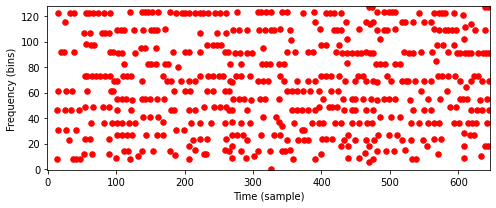

In [10]:
track_cmaps_7_3 = compute_constellation_maps(tracks, 7, 3) # κ = 7, τ = 3

fig, ax, im = plot_constellation_map(track_cmaps_7_3['tracks/810.mp3'], color='r', s=30)

### κ = 11, τ = 3

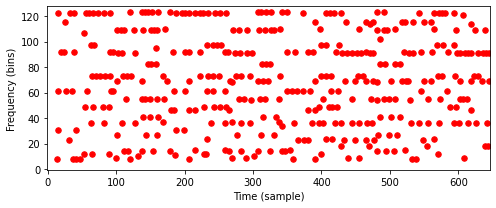

In [11]:
track_cmaps_11_3 = compute_constellation_maps(tracks, 11, 3) # κ = 11, τ = 3

fig, ax, im = plot_constellation_map(track_cmaps_11_3['tracks/810.mp3'], color='r', s=30)

### κ = 10, τ = 10

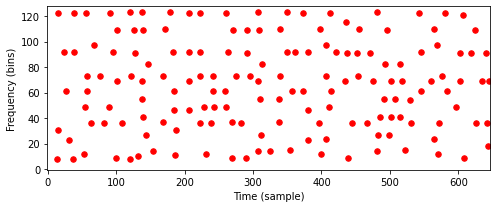

In [12]:
track_cmaps_10_10 = compute_constellation_maps(tracks, 10, 10) # κ = 10, τ = 10

fig, ax, im = plot_constellation_map(track_cmaps_10_10['tracks/810.mp3'], color='r', s=30)

### κ = 5, τ = 15

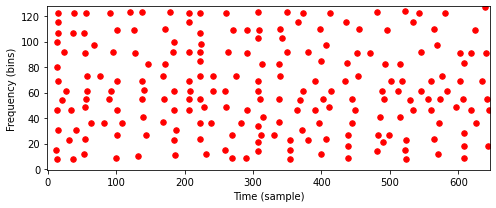

In [13]:
track_cmaps_5_15 = compute_constellation_maps(tracks, 5, 15) # κ = 5, τ = 15

fig, ax, im = plot_constellation_map(track_cmaps_5_15['tracks/810.mp3'], color='r', s=30)

# Creating the constellation maps for the queries

In this section, we create constellation maps for each of the queries, with the exact same parameter combinations, which we used for the database-tracks above.

Here we again load all filenames for the queries.

In [14]:
queries = load_filenames('queries')

### κ = 7, τ = 3

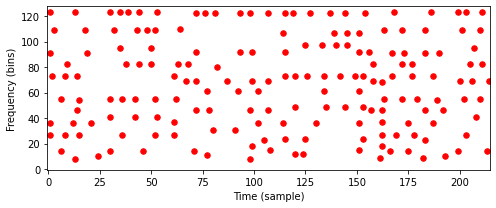

In [15]:
query_cmaps_7_3 = compute_constellation_maps(queries, 7, 3)

fig, ax, im = plot_constellation_map(query_cmaps_7_3['queries/810.mp3'], color='r', s=30)

### κ = 11, τ = 3

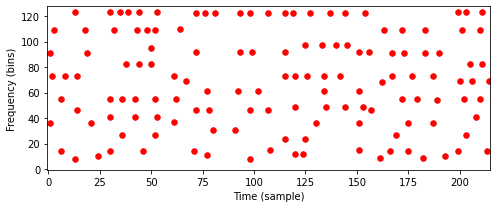

In [16]:
query_cmaps_11_3 = compute_constellation_maps(queries, 11, 3)

fig, ax, im = plot_constellation_map(query_cmaps_11_3['queries/810.mp3'], color='r', s=30)

### κ = 10, τ = 10

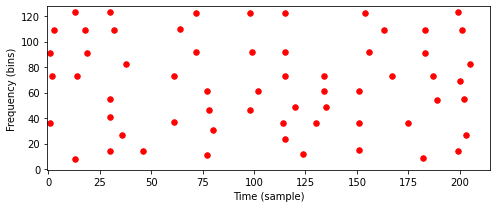

In [17]:
query_cmaps_10_10 = compute_constellation_maps(queries, 10, 10)

fig, ax, im = plot_constellation_map(query_cmaps_10_10['queries/810.mp3'], color='r', s=30)

### κ = 5, τ = 15

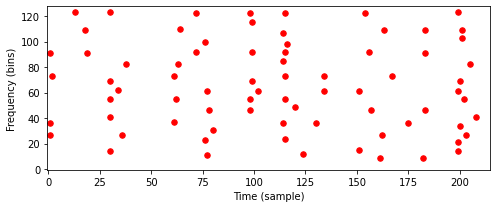

In [18]:
query_cmaps_5_15 = compute_constellation_maps(queries, 5, 15)

fig, ax, im = plot_constellation_map(query_cmaps_5_15['queries/810.mp3'], color='r', s=30)

# Matching

After preprocessing our tracks and queries, we can finally start the matching. We do the matching of queries and database-tracks for each of the previously defined parameter combinations. 

For each configuration, we follow a systematic process to identify the best match for each query:

- Iterate Through Queries: For every query, its constellation map is compared against all the database track constellation maps.
- Compute Matching Scores: Using the compute_matching_function, a score is calculated for each query-to-track combination.
- Track the Best Match: The track with the highest matching score for each query is identified as the best match. This is stored in a dictionary along with its corresponding score.
- Evaluate Results: We determine how many queries were correctly matched to their corresponding tracks by comparing the predicted matching track to the query's expected match (based on their filenames).

### κ = 7, τ = 3

In [37]:
query_best_scores_7_3 = {}
query_times_7_3 = []

for query_name, query_cmap in query_cmaps_7_3.items():
    best_score = 0
    best_name = None


    # Start timing for this query
    start_time = time.time()

    
    for track_name, track_cmap in track_cmaps_7_3.items():
        delta, shift_max = compute_matching_function(track_cmap, query_cmap, tol_freq=0, tol_time=0)

        if delta[shift_max] > best_score:
            best_score = delta[shift_max]
            best_name = track_name

    # End timing for this query
    end_time = time.time()
    query_times_7_3.append(end_time - start_time)

    query_best_scores_7_3[query_name] = {'matching_track': best_name, 'score': best_score}
    print(f"Matched query \"{query_name}\" to track \"{best_name}\", which took {query_times_7_3[-1]} seconds.")
    

count_matches = sum(1 for query, details in query_best_scores_7_3.items()
                     if details['matching_track'].split('/')[-1].replace('.mp3', '') in query.split('/')[-1])

average_time_7_3 = sum(query_times_7_3) / len(query_times_7_3)


print('\n\n\n')
print(f"Matched {count_matches} of {len(query_best_scores_7_3)} queries correctly.")
print(f"Average time per query: {average_time_7_3:.2f} seconds")

Matched query "queries/1390710.mp3" to track "tracks/1390710.mp3", which took 2.473388195037842 seconds.
Matched query "queries/1249910.mp3" to track "tracks/1249910.mp3", which took 1.3073322772979736 seconds.
Matched query "queries/152310.mp3" to track "tracks/152310.mp3", which took 2.1510238647460938 seconds.
Matched query "queries/1147910.mp3" to track "tracks/1147910.mp3", which took 1.126168966293335 seconds.
Matched query "queries/119410.mp3" to track "tracks/119410.mp3", which took 1.1070241928100586 seconds.
Matched query "queries/1400510_noise.mp3" to track "tracks/376310.mp3", which took 1.1109600067138672 seconds.
Matched query "queries/136810.mp3" to track "tracks/136810.mp3", which took 1.149275302886963 seconds.
Matched query "queries/887210_mobile.mp3" to track "tracks/887210.mp3", which took 1.0874109268188477 seconds.
Matched query "queries/1269810_noise.mp3" to track "tracks/1269810.mp3", which took 1.1343481540679932 seconds.
Matched query "queries/1400510_mobile.m

### κ = 11, τ = 3

In [38]:
query_best_scores_11_3 = {}
query_times_11_3 = []

for query_name, query_cmap in query_cmaps_11_3.items():
    best_score = 0
    best_name = None


    # Start timing for this query
    start_time = time.time()

    
    for track_name, track_cmap in track_cmaps_11_3.items():
        delta, shift_max = compute_matching_function(track_cmap, query_cmap, tol_freq=0, tol_time=0)

        if delta[shift_max] > best_score:
            best_score = delta[shift_max]
            best_name = track_name

    # End timing for this query
    end_time = time.time()
    query_times_11_3.append(end_time - start_time)

    query_best_scores_11_3[query_name] = {'matching_track': best_name, 'score': best_score}
    print(f"Matched query \"{query_name}\" to track \"{best_name}\", which took {query_times_11_3[-1]} seconds.")
    

count_matches = sum(1 for query, details in query_best_scores_11_3.items()
                     if details['matching_track'].split('/')[-1].replace('.mp3', '') in query.split('/')[-1])

average_time_11_3 = sum(query_times_11_3) / len(query_times_11_3)


print('\n\n\n')
print(f"Matched {count_matches} of {len(query_best_scores_11_3)} queries correctly.")
print(f"Average time per query: {average_time_11_3:.2f} seconds")

Matched query "queries/1390710.mp3" to track "tracks/1390710.mp3", which took 1.3956665992736816 seconds.
Matched query "queries/1249910.mp3" to track "tracks/1249910.mp3", which took 1.4906363487243652 seconds.
Matched query "queries/152310.mp3" to track "tracks/152310.mp3", which took 1.2981524467468262 seconds.
Matched query "queries/1147910.mp3" to track "tracks/1147910.mp3", which took 1.322429895401001 seconds.
Matched query "queries/119410.mp3" to track "tracks/119410.mp3", which took 1.237100601196289 seconds.
Matched query "queries/1400510_noise.mp3" to track "tracks/1418110.mp3", which took 1.637923240661621 seconds.
Matched query "queries/136810.mp3" to track "tracks/136810.mp3", which took 1.1454548835754395 seconds.
Matched query "queries/887210_mobile.mp3" to track "tracks/887210.mp3", which took 1.2261621952056885 seconds.
Matched query "queries/1269810_noise.mp3" to track "tracks/1269810.mp3", which took 2.559694766998291 seconds.
Matched query "queries/1400510_mobile.m

### κ = 10, τ = 10

In [39]:
query_best_scores_10_10 = {}
query_times_10_10 = []

for query_name, query_cmap in query_cmaps_10_10.items():
    best_score = 0
    best_name = None


    # Start timing for this query
    start_time = time.time()

    
    for track_name, track_cmap in track_cmaps_10_10.items():
        delta, shift_max = compute_matching_function(track_cmap, query_cmap, tol_freq=0, tol_time=0)

        if delta[shift_max] > best_score:
            best_score = delta[shift_max]
            best_name = track_name

    # End timing for this query
    end_time = time.time()
    query_times_10_10.append(end_time - start_time)

    query_best_scores_10_10[query_name] = {'matching_track': best_name, 'score': best_score}
    print(f"Matched query \"{query_name}\" to track \"{best_name}\", which took {query_times_10_10[-1]} seconds.")
    

count_matches = sum(1 for query, details in query_best_scores_10_10.items()
                     if details['matching_track'].split('/')[-1].replace('.mp3', '') in query.split('/')[-1])

average_time_10_10 = sum(query_times_10_10) / len(query_times_10_10)


print('\n\n\n')
print(f"Matched {count_matches} of {len(query_best_scores_10_10)} queries correctly.")
print(f"Average time per query: {average_time_10_10:.2f} seconds")

Matched query "queries/1390710.mp3" to track "tracks/1390710.mp3", which took 1.2396743297576904 seconds.
Matched query "queries/1249910.mp3" to track "tracks/1249910.mp3", which took 1.1969285011291504 seconds.
Matched query "queries/152310.mp3" to track "tracks/152310.mp3", which took 1.2876930236816406 seconds.
Matched query "queries/1147910.mp3" to track "tracks/1147910.mp3", which took 1.6178176403045654 seconds.
Matched query "queries/119410.mp3" to track "tracks/119410.mp3", which took 1.1180405616760254 seconds.
Matched query "queries/1400510_noise.mp3" to track "tracks/1192110.mp3", which took 1.4003651142120361 seconds.
Matched query "queries/136810.mp3" to track "tracks/136810.mp3", which took 1.8140642642974854 seconds.
Matched query "queries/887210_mobile.mp3" to track "tracks/887210.mp3", which took 1.8982489109039307 seconds.
Matched query "queries/1269810_noise.mp3" to track "tracks/1269810.mp3", which took 2.251842975616455 seconds.
Matched query "queries/1400510_mobil

### κ = 5, τ = 15

In [40]:
query_best_scores_5_15 = {}
query_times_5_15 = []

for query_name, query_cmap in query_cmaps_5_15.items():
    best_score = 0
    best_name = None


    # Start timing for this query
    start_time = time.time()

    
    for track_name, track_cmap in track_cmaps_5_15.items():
        delta, shift_max = compute_matching_function(track_cmap, query_cmap, tol_freq=0, tol_time=0)

        if delta[shift_max] > best_score:
            best_score = delta[shift_max]
            best_name = track_name

    # End timing for this query
    end_time = time.time()
    query_times_5_15.append(end_time - start_time)

    query_best_scores_5_15[query_name] = {'matching_track': best_name, 'score': best_score}
    print(f"Matched query \"{query_name}\" to track \"{best_name}\", which took {query_times_5_15[-1]} seconds.")
    

count_matches = sum(1 for query, details in query_best_scores_5_15.items()
                     if details['matching_track'].split('/')[-1].replace('.mp3', '') in query.split('/')[-1])

average_time_5_15 = sum(query_times_5_15) / len(query_times_5_15)


print('\n\n\n')
print(f"Matched {count_matches} of {len(query_best_scores_5_15)} queries correctly.")
print(f"Average time per query: {average_time_5_15:.2f} seconds")

Matched query "queries/1390710.mp3" to track "tracks/1390710.mp3", which took 1.735426425933838 seconds.
Matched query "queries/1249910.mp3" to track "tracks/1249910.mp3", which took 1.2210257053375244 seconds.
Matched query "queries/152310.mp3" to track "tracks/152310.mp3", which took 1.2193963527679443 seconds.
Matched query "queries/1147910.mp3" to track "tracks/1147910.mp3", which took 1.2383267879486084 seconds.
Matched query "queries/119410.mp3" to track "tracks/119410.mp3", which took 1.2088522911071777 seconds.
Matched query "queries/1400510_noise.mp3" to track "tracks/1400510.mp3", which took 1.332970380783081 seconds.
Matched query "queries/136810.mp3" to track "tracks/136810.mp3", which took 1.1078486442565918 seconds.
Matched query "queries/887210_mobile.mp3" to track "tracks/887210.mp3", which took 1.5777504444122314 seconds.
Matched query "queries/1269810_noise.mp3" to track "tracks/1269810.mp3", which took 1.8484487533569336 seconds.
Matched query "queries/1400510_mobile

 # Evaluation: